# Parcours Data scientist - Analysez des données nutritionnelles

In [1]:
# Récupération du fichier en local
import pandas as pd
import numpy as np
%pylab inline

dataraw = pd.read_csv('C:\Work\OpenClassrooms\data/fr.openfoodfacts.org.products.csv', sep="\t", low_memory=False)

print(dataraw.shape)
dataraw.head()

Populating the interactive namespace from numpy and matplotlib
(320772, 162)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# On remplace les '-' des noms de colonne par '_' pour pouvoir requêter
for col in dataraw.columns:
    if '-' in col:
        #print("rename %s in %s" % (col, col.replace('-', '_')))
        dataraw = dataraw.rename(columns= {col : col.replace('-', '_')})
#dataraw.head()

# Nettoyage

In [3]:
verbose = 1

# On enlève les colonnes dont toutes les valeurs sont manquantes
def RemoveNullColumn(p_df):
    print('On enlève les colonnes dont toutes les valeurs sont manquantes')
    nb = p_df.shape[1]
    p_df = p_df.dropna(axis=1, how='all')
    print("%i colonnes en moins (valeurs toutes nulles)" % (nb - p_df.shape[1]))
    print(p_df.shape)
    return p_df

# On enlève les lignes dont toutes les valeurs sont manquantes
def RemoveNullRow(p_df):
    print('On enlève les lignes dont toutes les valeurs sont manquantes')
    nb = p_df.shape[0]
    p_df = p_df.dropna(axis=0, how='all')
    print("%i lignes en moins (valeurs toutes nulles)" % (nb - p_df.shape[0]))
    print(p_df.shape)
    return p_df

# Méthode de suppression de colonne
def DropCol(p_df, p_col):
    if p_col in p_df.columns:
        p_df = p_df.drop([p_col], axis=1)
    return p_df

In [4]:
# On enlève les colonnes avec trop peu d'information (1 pour 1000)
def RemoveEmptyColumns(p_df, p_coef):
    print('On enlève les colonnes avec trop peu d''information :', p_coef)
    nb = 0
    nbMax = (int)(p_df.shape[0] * p_coef)
    for col in p_df.columns:
        if p_df[col].count() <= nbMax:
            if verbose == 1:
                print("%s : %i" % (col, p_df[col].count()))
            p_df = p_df.drop(col, axis=1)
            nb += 1
    print("%i colonnes enlevées (moins de %i valeurs)" % (nb, nbMax))
    print(p_df.shape)
    return p_df

In [5]:
my_data = RemoveNullColumn(dataraw)
# On enlève les colonnes avec moins de 1 ligne pour 1000 remplie
my_data = RemoveEmptyColumns(my_data, 0.005)
my_data = RemoveNullRow(my_data)

On enlève les colonnes dont toutes les valeurs sont manquantes
16 colonnes en moins (valeurs toutes nulles)
(320772, 146)
On enlève les colonnes avec trop peu dinformation : 0.005
cities : 23
allergens_fr : 19
energy_from_fat_100g : 857
caprylic_acid_100g : 1
capric_acid_100g : 2
lauric_acid_100g : 4
myristic_acid_100g : 1
palmitic_acid_100g : 1
stearic_acid_100g : 1
arachidic_acid_100g : 24
behenic_acid_100g : 23
montanic_acid_100g : 1
omega_3_fat_100g : 841
alpha_linolenic_acid_100g : 186
eicosapentaenoic_acid_100g : 38
docosahexaenoic_acid_100g : 78
omega_6_fat_100g : 188
linoleic_acid_100g : 149
arachidonic_acid_100g : 8
gamma_linolenic_acid_100g : 24
dihomo_gamma_linolenic_acid_100g : 23
omega_9_fat_100g : 21
oleic_acid_100g : 13
gondoic_acid_100g : 14
sucrose_100g : 72
glucose_100g : 26
fructose_100g : 38
lactose_100g : 262
maltose_100g : 4
maltodextrins_100g : 11
starch_100g : 266
polyols_100g : 414
casein_100g : 27
serum_proteins_100g : 16
nucleotides_100g : 9
beta_carotene_100

## Un peu de visualisation

In [6]:
# select non-numeric columns
df_str = my_data.select_dtypes(exclude=[np.number])
df_str.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,d,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,b,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,d,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","A compléter,Informations nutritionnelles compl...",NaN,NaN,NaN,NaN


In [7]:
# On recherche les colonnes avec peu de valeurs différentes, donc succeptibles d'être catégorisées
desc = df_str.describe()
for col in df_str.columns:
    if (desc[col][1]) < 100:
        print (col)
        print (desc[col])


ingredients_from_palm_oil_tags
count               4835
unique                14
top       huile-de-palme
freq                4586
Name: ingredients_from_palm_oil_tags, dtype: object
nutrition_grade_fr
count     221210
unique         5
top            d
freq       62763
Name: nutrition_grade_fr, dtype: object
pnns_groups_1
count       91513
unique         14
top       unknown
freq        22624
Name: pnns_groups_1, dtype: object
pnns_groups_2
count       94491
unique         42
top       unknown
freq        22624
Name: pnns_groups_2, dtype: object


In [8]:
# Origine
df_str.origins.describe()

count      22190
unique      4840
top       France
freq        5171
Name: origins, dtype: object

In [9]:
# 
df_str.manufacturing_places.describe()

count      36501
unique      7308
top       France
freq        9371
Name: manufacturing_places, dtype: object

In [10]:
# 
df_str.purchase_places.describe()

count      58193
unique      5120
top       France
freq       11762
Name: purchase_places, dtype: object

In [11]:
# 
df_str.first_packaging_code_geo.describe()

count                   18803
unique                   1602
top       47.633333,-2.666667
freq                      279
Name: first_packaging_code_geo, dtype: object

In [12]:
# 
my_data.additives.describe()

count                                                248905
unique                                               196069
top        [ extra-virgin-olive-oil -> en:extra-virgin-o...
freq                                                    397
Name: additives, dtype: object

In [13]:
# 
my_data.additives_fr.describe()

count                154680
unique                41537
top       E322 - Lécithines
freq                   8264
Name: additives_fr, dtype: object

In [14]:
# 
my_data.additives_n.describe()

count    248939.000000
mean          1.936024
std           2.502019
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          31.000000
Name: additives_n, dtype: float64

In [15]:
# 
my_data.additives_tags.describe()

count      154680
unique      41537
top       en:e322
freq         8264
Name: additives_tags, dtype: object

In [16]:
# 
my_data.ingredients_from_palm_oil_n.describe()

count    248939.000000
mean          0.019659
std           0.140524
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: ingredients_from_palm_oil_n, dtype: float64

In [17]:
# 
my_data.ingredients_from_palm_oil_tags.describe()

count               4835
unique                14
top       huile-de-palme
freq                4586
Name: ingredients_from_palm_oil_tags, dtype: object

In [18]:
# 
my_data.ingredients_that_may_be_from_palm_oil_n.describe()

count    248939.000000
mean          0.055246
std           0.269207
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: ingredients_that_may_be_from_palm_oil_n, dtype: float64

In [19]:
# 
my_data.ingredients_that_may_be_from_palm_oil_tags.describe()

count                   11696
unique                    160
top       e160a-beta-carotene
freq                     2843
Name: ingredients_that_may_be_from_palm_oil_tags, dtype: object

In [20]:
my_data[my_data.nutrition_grade_fr.notnull()].sample(50)[['product_name','main_category','pnns_groups_1','pnns_groups_2','nutrition_grade_fr','energy_100g']].drop_duplicates()

,product_name,main_category,pnns_groups_1,pnns_groups_2,nutrition_grade_fr,energy_100g
269699,NaN,en:chocolates,Sugary snacks,Chocolate products,e,2144.0
209948,Thon au naturel,en:tunas,Fish Meat Eggs,Fish and seafood,b,494.0
78389,Instant Mash Potatoes,NaN,NaN,NaN,a,1523.0
244980,Méridionale,en:frozen-foods,Composite foods,One-dish meals,a,367.0
4720,"Gel Bites, Black Cherry",NaN,NaN,NaN,a,75.0
52714,Zesty Sauces & Mixes,NaN,NaN,NaN,c,96.0
62603,Uncured Hickory Smoked Bacon,NaN,NaN,NaN,e,1954.0
166368,"Cashew Nuts, Brazilian Superfood",NaN,NaN,NaN,c,2389.0
244030,2 Cassolettes noix de St Jacques et crevettes,en:frozen-foods,Composite foods,One-dish meals,c,447.0
60043,Mixed Nuts With Sea Salt,NaN,NaN,NaN,d,2531.0


In [21]:
# select numeric columns
df_num = my_data.select_dtypes(include=[np.number])
df_num.head()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated_fat_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,trans_fat_100g,cholesterol_100g,...,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fruits_vegetables_nuts_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,2243.0,28.57,28.57,NaN,NaN,0.0,0.018,...,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,14.0,14.0
2,0.0,0.0,0.0,1941.0,17.86,0.00,NaN,NaN,0.0,0.000,...,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,0.0,0.0,0.0,2540.0,57.14,5.36,NaN,NaN,NaN,NaN,...,0.143,NaN,0.00514,NaN,NaN,NaN,NaN,NaN,12.0,12.0
4,0.0,0.0,0.0,1552.0,1.43,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_num.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated_fat_100g,monounsaturated_fat_100g,polyunsaturated_fat_100g,trans_fat_100g,cholesterol_100g,...,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fruits_vegetables_nuts_100g,nutrition_score_fr_100g,nutrition_score_uk_100g
count,248939.000000,248939.000000,248939.000000,2.611130e+05,243891.000000,229554.000000,22823.000000,22859.000000,143298.000000,144090.000000,...,141050.000000,5845.000000,140462.000000,6253.000000,3929.000000,2106.000000,1620.000000,3036.000000,221210.000000,221210.000000
mean,1.936024,0.019659,0.055246,1.141915e+03,12.730379,5.129932,10.425055,6.312493,0.073476,0.020071,...,0.125163,0.617282,0.003652,0.534143,0.007950,0.025794,0.003014,31.458587,9.165535,9.058049
std,2.502019,0.140524,0.269207,6.447154e+03,17.578747,8.014238,17.076167,10.832591,1.540223,0.358062,...,3.318263,12.058090,0.214408,13.498653,0.080953,0.914247,0.028036,31.967918,9.055903,9.183589
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-3.570000,0.000000,...,0.000000,0.000000,-0.000260,0.000000,0.000000,-6.896552,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,3.770000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.094000,0.000000,0.021000,0.001150,0.000177,0.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1.100000e+03,5.000000,1.790000,4.000000,2.220000,0.000000,0.000000,...,0.035000,0.206000,0.001010,0.075000,0.003700,0.000417,0.001000,23.000000,10.000000,9.000000
75%,3.000000,0.000000,0.000000,1.674000e+03,20.000000,7.140000,10.710000,7.140000,0.000000,0.020000,...,0.106000,0.357000,0.002400,0.141000,0.007500,0.001000,0.002000,51.000000,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,557.140000,98.000000,369.000000,95.238000,...,694.737000,559.459000,50.000000,657.143000,4.000000,37.600000,0.700000,100.000000,40.000000,40.000000


## Autres colonnes

>On a encore beaucoup de colonnes dont certaines pourraient être utiles pour un client recherchant des aliments sains :
>>- Présence d'additifs

>>- Ingrédients contenant de l'huile de palme

>>- Origine, pays de provenance et empreinte carbone pour une recherche de circuit court...

>Ces colonnes demanderait un peu plus de temps d'analyse donc dans un premier temps on va se concentrer sur les valeurs numériques que l'on a et ne garder que les colonnes du type xxx_100g.

>On va se baser sur le score français pour la suite (on verra que le score uk et le grade sont des informations redondantes) 


In [23]:
# On ne garde que les colonnes avec des valeurs nutritionnelles, les scores et les groupes
def GetNut(p_df):
    ret = p_df.copy()
    for i in ret.columns:
        if not ('_100g' in i or 'nutrition' in i or 'pnns_groups' in i):
            #print(i)
            ret = ret.drop(i, axis=1)
    print("%i colonnes en moins (colonnes sans valeurs nutritionnelles)" % (p_df.shape[1]-ret.shape[1]))
    print(ret.shape)
    return RemoveNullRow(ret)

In [24]:
my_data_nut = GetNut(my_data)

54 colonnes en moins (colonnes sans valeurs nutritionnelles)
(320772, 39)
On enlève les lignes dont toutes les valeurs sont manquantes
32499 lignes en moins (valeurs toutes nulles)
(288273, 39)


## Valeurs négatives

In [25]:
def RemoveNegatives(p_df):
    print('On enlève les valeurs négatives')
    for i in p_df.columns:
        # Il y a des scores négatifs mais c'est normal
        if 'nutrition' in i: continue
        if p_df[i].dtype == 'object': continue
        neg = p_df[p_df[i] < 0].shape[0]
        if neg > 0:
            if verbose > 0:
                print(neg, 'valeurs négatives pour', i)
        # On remplace par 0
        #p_df[i] = p_df[i].clip(lower=0)
        # On supprime
        p_df = p_df[(p_df[i] < 0) == False]
    print(p_df.shape)
    return p_df

In [26]:
verbose = 1
my_data_nut = RemoveNegatives(my_data_nut)

On enlève les valeurs négatives
4 valeurs négatives pour trans_fat_100g
7 valeurs négatives pour sugars_100g
1 valeurs négatives pour fiber_100g
3 valeurs négatives pour proteins_100g
1 valeurs négatives pour vitamin_a_100g
1 valeurs négatives pour vitamin_c_100g
8 valeurs négatives pour pantothenic_acid_100g
1 valeurs négatives pour iron_100g
1 valeurs négatives pour copper_100g
(288246, 39)


## Outliers

In [27]:
def RemoveOutliers(p_df):
    print('On enlève les outliers')
    for i in p_df.columns:
        if 'nutrition' in i: continue
        if my_data_nut[i].dtype == 'object': continue

        # Etude sur un échantillon représentatif (les valeurs positives)
        df = p_df[p_df[i] > 0]
        if df.shape[0] == 0:
            continue
    #    nbTot = my_data_nut[my_data_nut[i]>0].shape[0]
    #    if nbTot < 5000:
    #        print("Trop peu de valeurs (%i) pour %s" % (nbTot, i))
    #        continue

        # Outliers
        q75, q25 = np.percentile(df[i], [75 ,25])
        iqr = q75 - q25

        nbmax = q75 + (iqr*1.5)
        nbmax = q75 + (iqr*5) # Je prends une valeur plus haute car il sinon on sort trop de lignes
        nbOutliers = p_df[p_df[i]>nbmax].shape[0]
        if nbOutliers > 0:
            if verbose > 0:
                print("%i valeurs supérieures à %f pour %s (max=%f)" % (nbOutliers, nbmax, i, np.max(p_df[i])))
            p_df = p_df[(p_df[i] > nbmax) == False]
    
    print(p_df.shape)
    return p_df

In [28]:
verbose = 1
my_data_nut = RemoveOutliers(my_data_nut)

On enlève les outliers
27 valeurs supérieures à 7894.000000 pour energy_100g (max=3251373.000000)
624 valeurs supérieures à 56.500000 pour saturated_fat_100g (max=100.000000)
3 valeurs supérieures à 85.320000 pour monounsaturated_fat_100g (max=100.000000)
355 valeurs supérieures à 55.310000 pour polyunsaturated_fat_100g (max=98.000000)
61 valeurs supérieures à 19.020000 pour trans_fat_100g (max=369.000000)
241 valeurs supérieures à 0.351000 pour cholesterol_100g (max=95.238000)
1 valeurs supérieures à 319.410000 pour carbohydrates_100g (max=2916.670000)
1480 valeurs supérieures à 24.900000 pour fiber_100g (max=178.000000)
388 valeurs supérieures à 55.500000 pour proteins_100g (max=100.000000)
5539 valeurs supérieures à 8.369300 pour salt_100g (max=64312.800000)
182 valeurs supérieures à 3.130724 pour sodium_100g (max=3.294000)
8 valeurs supérieures à 56.000000 pour alcohol_100g (max=97.900000)
2055 valeurs supérieures à 0.001448 pour vitamin_a_100g (max=26.700000)
72 valeurs supérieure

## Valeurs manquantes

In [29]:
# On met la moyenne dans les valeurs nutritives manquantes
def ReplaceByMean(p_df):
    print('On remplace les valeurs manquantes par la moyenne')
    for i in p_df.columns:
        if p_df[i].dtype == 'object': continue
        if not ('nutrition' in i):
            mean = np.mean(p_df[i])
            p_df[i] = p_df[i].fillna(mean)
    return p_df

# En fait il y a tellement de valeurs manquantes que les remplacer par la moyenne ferait un gros paquet au centre
# Je préfère mettre 0 pour les calculs globaux et ensuite pour l'analyse fine n'utiliser que les valeurs strictement positives 
def ReplaceByZero(p_df):
    print('On remplace les valeurs manquantes par la zéro')
    for i in p_df.columns:
        if p_df[i].dtype == 'object': continue
        if not ('nutrition' in i):
            p_df[i] = p_df[i].fillna(0)
    return p_df

In [30]:
my_data_nut = ReplaceByMean(my_data_nut)

On remplace les valeurs manquantes par la moyenne


## Résumé

In [31]:
# Permet de faire un nettoyage différent rapidement
#verbose = 1
# On enlève les colonnes avec moins de 5 lignes pour 1000 remplies
#my_data = RemoveEmptyColumns(dataraw, 0.005)
#my_data_nut = GetNut(my_data)
#my_data_nut = RemoveNegatives(my_data_nut)
#my_data_nut = RemoveOutliers(my_data_nut)
#my_data_nut = RemoveNullRow(my_data_nut)
#my_data_nut = ReplaceByMean(my_data_nut)   # ou ReplaceByZero

## On exporte un fichier light pour une étude rapide

In [32]:
col_score = ['nutrition_score_fr_100g', 'nutrition_score_uk_100g', 'nutrition_grade_fr']

# On ne garde que les scores non nulls
dflight = my_data_nut.copy()
dflight.dropna(subset=col_score, inplace=True)
print(dflight.shape)
dflight.to_csv('clean_products_light.csv', sep="\t")

# On travaille aussi sur un échantillon pour la mémoire et le temps de calcul
dflight = dflight.sample(30000)
print(dflight.shape)
dflight.to_csv('clean_products_light_sample.csv', sep="\t")

(206483, 39)
(30000, 39)


## Tests de modèles

In [33]:
verbose = 0

# On travail sur un échantillon pour réduire le temps de calcul
my_data = RemoveEmptyColumns(dataraw.sample(15000), 0.005)
my_data_nut = GetNut(my_data)
my_data_nut = RemoveNegatives(my_data_nut)
my_data_nut = RemoveOutliers(my_data_nut)
my_data_nut = RemoveNullRow(my_data_nut)
my_data_nut = ReplaceByMean(my_data_nut)

On enlève les colonnes avec trop peu dinformation : 0.005
70 colonnes enlevées (moins de 75 valeurs)
(15000, 92)
54 colonnes en moins (colonnes sans valeurs nutritionnelles)
(15000, 38)
On enlève les lignes dont toutes les valeurs sont manquantes
1557 lignes en moins (valeurs toutes nulles)
(13443, 38)
On enlève les valeurs négatives
(13443, 38)
On enlève les outliers
(12487, 38)
On enlève les lignes dont toutes les valeurs sont manquantes
0 lignes en moins (valeurs toutes nulles)
(12487, 38)
On remplace les valeurs manquantes par la moyenne


In [34]:
# On enlève les colonnes issues de l'étude de corrélation (voir la partie exploration)
dropCols = ['monounsaturated_fat_100g', 'polyunsaturated_fat_100g', 'trans_fat_100g', 'proteins_100g', 'alcohol_100g', 'vitamin_a_100g', 'vitamin_d_100g', 'vitamin_b1_100g', 'vitamin_b2_100g', 'vitamin_pp_100g', 'vitamin_b6_100g', 'vitamin_b9_100g', 'folates_100g', 'vitamin_b12_100g', 'pantothenic_acid_100g', 'potassium_100g', 'calcium_100g', 'phosphorus_100g', 'iron_100g', 'magnesium_100g', 'zinc_100g', 'copper_100g', 'manganese_100g', 'fruits_vegetables_nuts_100g']
for col in dropCols:
    my_data_nut = DropCol(my_data_nut, col)

## Recherche des scores manquants

In [35]:
from sklearn import metrics, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

# On prend un échantillon pour des tests plus rapide
dfreg = my_data_nut.sample(10000)
dfreg = DropCol(dfreg, 'pnns_groups_1')
dfreg = DropCol(dfreg, 'pnns_groups_2')

In [36]:
# Séparation des valeurs nulles et non nulles
dfScoreNull = dfreg[pd.isnull(dfreg.nutrition_score_fr_100g)].copy()
print('Il y a', dfScoreNull.shape[0], 'valeurs nulles')
dfScoreNotNull = dfreg[pd.notnull(dfreg.nutrition_score_fr_100g)]
print('Il y a', dfScoreNotNull.shape[0], 'valeurs non nulles')

# On sépare les colonnes de scores sur les valeurs non nulles
X = dfScoreNotNull.drop(col_score, axis=1)
y = dfScoreNotNull.nutrition_score_fr_100g

# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Standardisation
std_scale = preprocessing.StandardScaler(copy=True).fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

Il y a 2291 valeurs nulles
Il y a 7709 valeurs non nulles


### Par régression knn

In [37]:
k_range = range(1, 20)
k_score = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
    k_score.append(-scores.mean())

([<matplotlib.axis.XTick at 0x1121a0b8>,
 <a list of 10 Text xticklabel objects>)

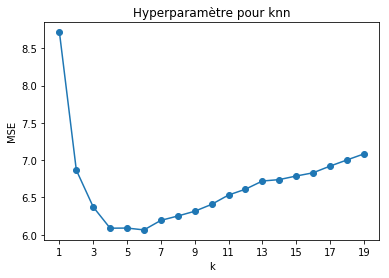

In [38]:
plt.plot(k_range, k_score, 'o-')
plt.xlabel("k")
plt.ylabel("MSE")
plt.title("Hyperparamètre pour knn")
plt.xticks(range(1, 20, 2))

In [39]:
# On fait un grid search pour trouver le meilleur k
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
mse = 'neg_mean_squared_error'
gs = GridSearchCV(KNeighborsRegressor(), param_grid, scoring=mse, cv = 5)

gs.fit(X_train_std, y_train)
me = []
err = []
for mean, std, params in zip(gs.cv_results_['mean_test_score'], # score moyen
                             gs.cv_results_['std_test_score'], # écart-type du score
                             gs.cv_results_['params'] # valeur de l'hyperparamètre
                            ):
    print ("\t%s = %0.3f (+/-%0.03f) for %r" % ('MSE', -mean, std * 2, params))
    me.append(mean)
    err.append(2*std)

kBest = gs.best_params_['n_neighbors']
print ('Meilleur k : %r' % kBest)

	MSE = 6.372 (+/-0.803) for {'n_neighbors': 3}
	MSE = 6.089 (+/-0.597) for {'n_neighbors': 5}
	MSE = 6.192 (+/-0.695) for {'n_neighbors': 7}
	MSE = 6.314 (+/-0.481) for {'n_neighbors': 9}
	MSE = 6.532 (+/-0.459) for {'n_neighbors': 11}
	MSE = 6.720 (+/-0.536) for {'n_neighbors': 13}
	MSE = 6.787 (+/-0.567) for {'n_neighbors': 15}
Meilleur k : 5


In [40]:
# Entrainement du meilleur modèle et score sur le jeu de test
knn = KNeighborsRegressor(n_neighbors=kBest)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print ("Erreur sur le jeu de test : MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))

Erreur sur le jeu de test : MSE = 6.085


### Par régression linéaire

In [41]:
from sklearn import linear_model
clf = GridSearchCV(linear_model.LinearRegression(), {}, cv=10, refit=True)
clf.fit(X_train_std, y_train)
print("Erreur du modèle linéaire : MSE : %.3f" % metrics.mean_squared_error(clf.best_estimator_.predict(X_test_std), y_test))

Erreur du modèle linéaire : MSE : 14.517


### Par une méthode naïve

In [42]:
# Méthode naive par la moyenne pour comparer
from sklearn import dummy
dum = dummy.DummyRegressor(strategy='mean')
# Entraînement
dum.fit(X_train_std, y_train)
# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)
# Evaluate
print ("Méthode naive par la moyenne : MSE = %.2f" % metrics.mean_squared_error(y_test, y_pred_dum))

Méthode naive par la moyenne : MSE = 83.40


Notre modèle knn est bien meilleur que le modèle naif

On peut maintenant remplir les valeurs manquantes

In [43]:
# Recherche des scores nulls
X = dfScoreNull.drop(col_score, axis=1)

# Standardisation
std_scale = preprocessing.StandardScaler(copy=True).fit(X)
X_scaled = std_scale.transform(X)

yScoreNull = knn.predict(X_scaled)

# Remplacement des nulls
dfScoreNull.loc[:,'nutrition_score_fr_100g'] = yScoreNull

dfreg = dfScoreNotNull.append(dfScoreNull)
dfreg.shape

(10000, 13)

## Recherche des grades manquants

In [44]:
# Pour la classification
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Séparation des valeurs nulles et non nulles
dfScoreNull = dfreg[pd.isnull(dfreg.nutrition_grade_fr)].copy()
print('Il y a', dfScoreNull.shape[0], 'valeurs nulles')
dfScoreNotNull = dfreg[pd.notnull(dfreg.nutrition_grade_fr)]
print('Il y a', dfScoreNotNull.shape[0], 'valeurs non nulles')

Il y a 2291 valeurs nulles
Il y a 7709 valeurs non nulles


In [45]:
# On sépare les colonnes de scores sur les valeurs non nulles
X = dfScoreNotNull.drop(col_score, axis=1)
y = dfScoreNotNull.nutrition_grade_fr

# Transformation des grades en valeurs de 1 à 5, correspondant à (['a', 'b', 'c', 'd', 'e'])
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y)
label_encoder.classes_

# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
# Standardisation
std_scale = preprocessing.StandardScaler(copy=True).fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

### Par classification knn

In [46]:
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}
mse = 'neg_mean_squared_error'
gs = GridSearchCV(KNeighborsClassifier(), param_grid, scoring=mse, cv = StratifiedKFold(n_splits=5))                                 

gs.fit(X_train_std, y_train)
me = []
err = []
for mean, std, params in zip(gs.cv_results_['mean_test_score'], # score moyen
                             gs.cv_results_['std_test_score'], # écart-type du score
                             gs.cv_results_['params'] # valeur de l'hyperparamètre
                            ):
    print ("\t%s = %0.3f (+/-%0.03f) for %r" % ('MSE', -mean, std * 2, params))
    me.append(mean)
    err.append(2*std)
kBest = gs.best_params_['n_neighbors']
print ('Meilleur k : %r' % kBest)

	MSE = 0.394 (+/-0.049) for {'n_neighbors': 3}
	MSE = 0.368 (+/-0.060) for {'n_neighbors': 5}
	MSE = 0.376 (+/-0.059) for {'n_neighbors': 7}
	MSE = 0.385 (+/-0.044) for {'n_neighbors': 9}
	MSE = 0.384 (+/-0.065) for {'n_neighbors': 11}
	MSE = 0.400 (+/-0.067) for {'n_neighbors': 13}
	MSE = 0.407 (+/-0.062) for {'n_neighbors': 15}
Meilleur k : 5


In [47]:
# Entrainement du meilleur modèle
knn = KNeighborsClassifier(n_neighbors=kBest)
knn.fit(X_train_std, y_train)
y_pred = knn.predict(X_test_std)
print ("Erreur du modèle knn : MSE = %.3f" % metrics.mean_squared_error(y_test, y_pred))

Erreur du modèle knn : MSE = 0.331


### Par régression linéaire

In [48]:
clf = GridSearchCV(linear_model.LinearRegression(), {}, cv=10, refit=True)
clf.fit(X_train_std, y_train)
print("Erreur du modèle linéaire : MSE : %.3f" % metrics.mean_squared_error(clf.best_estimator_.predict(X_test_std), y_test))

Erreur du modèle linéaire : MSE : 0.511


### Par une méthode naïve

In [49]:
# Méthode naive par la classe la plus fréquente pour comparer
dum = dummy.DummyClassifier(strategy='most_frequent')
# Entraînement
dum.fit(X_train_std, y_train)
# Prédiction sur le jeu de test
y_pred_dum = dum.predict(X_test_std)
# Evaluate
print ("Méthode naive : MSE = %.2f" % metrics.mean_squared_error(y_test, y_pred_dum))

Méthode naive : MSE = 2.58


Notre modèle knn est bien meilleur que le modèle naif

On peut maintenant remplir les valeurs manquantes

In [50]:
# Recherche des scores nulls
X = dfScoreNull.drop(col_score, axis=1)

# Standardisation
std_scale = preprocessing.StandardScaler(copy=True)
X_scaled = std_scale.fit(X).transform(X)

yScoreNull = knn.predict(X_scaled)

#On remet les grades
yScoreNull = label_encoder.inverse_transform(yScoreNull)

# Remplacement des nulls
dfScoreNull.loc[:,'nutrition_grade_fr'] = yScoreNull

dfreg = dfScoreNotNull.append(dfScoreNull)
dfreg.shape

(10000, 13)

# Export des résultats

In [51]:
dfreg.to_csv('products_score_filled.csv', sep="\t")